In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
#from sensitivity_plot import sensitivity_plot
import statsmodels.api as sm
import numbers
from sklearn.metrics import mean_squared_error
import math
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
import pylab 
import scipy.stats as stats
from whitebox.eval import WhiteBoxSensitivity
from sklearn.model_selection import cross_val_score

C:\Users\dbyler\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv('./datasets/final_data.csv', low_memory=False)
#final_data = final_data.drop('LanguageRecommendationSelect', axis=1)

In [3]:
#for details on data cleaning see'Data_Cleaning.ipynb'
#raw data has 5617 rows
df.shape

(5617, 282)

In [4]:
#get rid of all NAs
#final_data = final_data.dropna()
df = df.reset_index(drop=True)
df.shape

(5617, 282)

In [5]:
dependentVar = 'JobSatisfaction'

In [6]:
df[dependentVar].describe()

count    5617.000000
mean        6.727079
std         2.166445
min         1.000000
25%         5.000000
50%         7.000000
75%         8.000000
max        10.000000
Name: JobSatisfaction, dtype: float64

In [7]:
spike_cols = [col for col in df.columns if 'WorkToolsSelect' in col]
print(spike_cols)


['WorkToolsSelect_Amazon Machine Learning', 'WorkToolsSelect_Amazon Web services', 'WorkToolsSelect_Angoss', 'WorkToolsSelect_C/C++', 'WorkToolsSelect_Cloudera', 'WorkToolsSelect_DataRobot', 'WorkToolsSelect_Flume', 'WorkToolsSelect_Google Cloud Compute', 'WorkToolsSelect_Hadoop/Hive/Pig', 'WorkToolsSelect_IBM Cognos', 'WorkToolsSelect_IBM SPSS Modeler', 'WorkToolsSelect_IBM SPSS Statistics', 'WorkToolsSelect_IBM Watson / Waton Analytics', 'WorkToolsSelect_Impala', 'WorkToolsSelect_Java', 'WorkToolsSelect_Julia', 'WorkToolsSelect_Jupyter notebooks', 'WorkToolsSelect_KNIME (commercial version)', 'WorkToolsSelect_KNIME (free version)', 'WorkToolsSelect_MATLAB/Octave', 'WorkToolsSelect_Mathematica', 'WorkToolsSelect_Microsoft Azure Machine Learning', 'WorkToolsSelect_Microsoft Excel Data Mining', 'WorkToolsSelect_Microsoft R Server (Formerly Revolution Analytics)', 'WorkToolsSelect_Microsoft SQL Server Data Mining', 'WorkToolsSelect_Minitab', 'WorkToolsSelect_NoSQL', 'WorkToolsSelect_Orac

In [8]:
#drop columns with WorkToolsSelect_C as they are sparse and not important here and have a ++ that is problematic
df = df.drop(spike_cols, axis=1)

In [9]:

#transform the string variables to categorical variables
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))

# select only those columns which are categorical in nature and make a copy for modeling
df.select_dtypes(include = ['category'])
model_df = df.copy(deep = True)

# create dummies example using all categorical columns
# this naming convention must be precise for WhiteBox to recognize what dummies are associated with what variables
dummies = pd.concat([pd.get_dummies(model_df.loc[:, col], prefix = col) for col in model_df.select_dtypes(include = ['category']).columns], axis = 1)

# add the dummies to the numeric dataframe for modeling
finaldf = pd.concat([model_df.select_dtypes(include = [np.number]), dummies], axis = 1)


In [10]:
#make train and test samles
X_train, X_test, y_train, y_test = train_test_split(finaldf.loc[:, finaldf.columns != dependentVar], df.loc[:, dependentVar], test_size=0.1, random_state=42)

In [11]:
#make a Random Forest object trained to predict Job Satisfaction 
Rf = RandomForestRegressor(n_estimators=50, min_weight_fraction_leaf = .01,  oob_score=True)
#Rf.fit(xTrain,final_data['JobSatisfaction'])
Rf.fit(finaldf.loc[:, finaldf.columns != dependentVar],df.loc[:, dependentVar])



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.01, n_estimators=50, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [12]:
scores = cross_val_score(Rf, finaldf.loc[:, finaldf.columns != dependentVar], df.loc[:, dependentVar], cv=5)
print(scores)
print(scores.mean())

[0.19073285 0.18732228 0.16281516 0.17681372 0.15456976]
0.17445075468843524


In [13]:
est = GradientBoostingRegressor(n_estimators=200, learning_rate=.05,  min_weight_fraction_leaf = .01, loss='ls', random_state = 25)
est.fit(finaldf.loc[:, finaldf.columns != dependentVar], df.loc[:, dependentVar])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.01,
             n_estimators=200, presort='auto', random_state=25,
             subsample=1.0, verbose=0, warm_start=False)

In [14]:
scores = cross_val_score(est, finaldf.loc[:, finaldf.columns != dependentVar], df.loc[:, dependentVar], cv=5)
print(scores)
print(scores.mean())

[0.21088531 0.21749139 0.21508961 0.21783875 0.18747445]
0.20975590330218194


In [15]:
#fit lasso model
lass = linear_model.Lasso(alpha=0.03)
lass.fit(finaldf.loc[:, finaldf.columns != dependentVar],df.loc[:, dependentVar])

Lasso(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [16]:
scores = cross_val_score(lass, finaldf.loc[:, finaldf.columns != dependentVar], df.loc[:, dependentVar], cv=5)
print(scores)
print(scores.mean())

[0.18849858 0.20762855 0.20800129 0.19818511 0.18829835]
0.19812237681656422


In [17]:
#generate coefficients and then print them
coef_dict = {}
for coef, feat in zip(lass.coef_,X_train.columns):
    if coef != 0:
        coef_dict[feat] = round(coef,3)

In [18]:
pd.DataFrame(list(coef_dict.items()), columns=['Varialbe', 'Coefficient']).sort_values(['Coefficient'])

,Varialbe,Coefficient
29,WorkChallengeFrequencyPolitics_Most of the time,-0.554
21,TitleFit_Poorly,-0.441
39,SalaryChange_Has stayed about the same (has no...,-0.369
40,Continent_Asia,-0.349
37,RemoteWork_Never,-0.170
33,WorkChallengeFrequencyTalent_Most of the time,-0.167
32,WorkChallengeFrequencyDirtyData_Never,-0.139
45,CurrentEmployerType_Employed by a company that...,-0.131
36,WorkChallengeFrequencyDataAccess_Never,-0.113
22,DataScienceIdentitySelect_No,-0.076


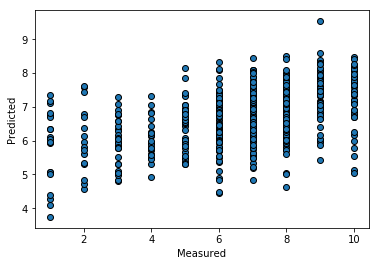

In [19]:
#test validity of assumptions of the regression's coefficients 
y = y_test
predicted = lass.predict(X_test)
fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
#ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=6)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

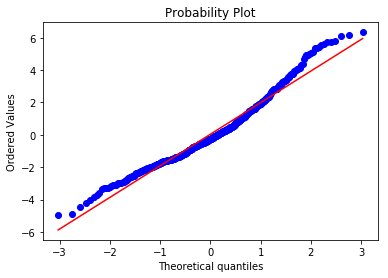

In [20]:
y = y_test
predicted = lass.predict(X_test)
error2 = (predicted-y_test)
stats.probplot(error2, dist="norm", plot=pylab)
pylab.show()

Age


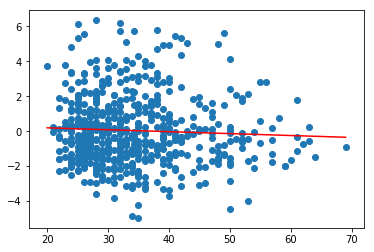

LearningCategorySelftTaught


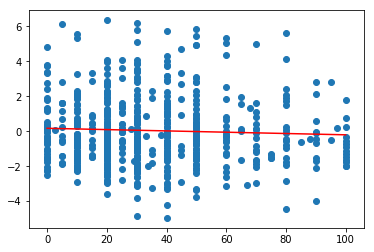

LearningCategoryOnlineCourses


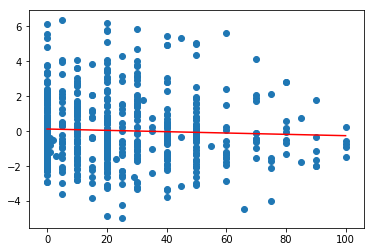

LearningCategoryWork


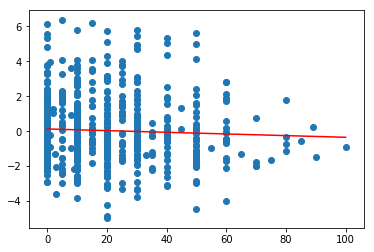

LearningCategoryKaggle


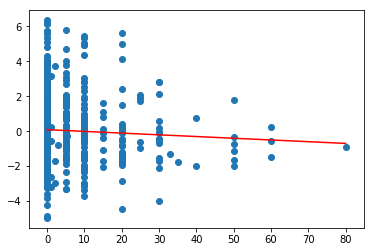

LearningCategoryOther


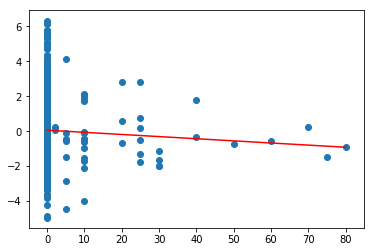

TimeGatheringData


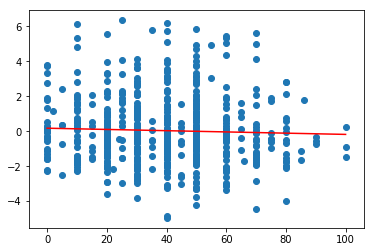

TimeModelBuilding


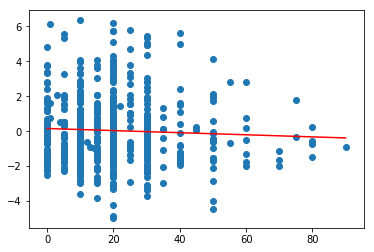

TimeProduction


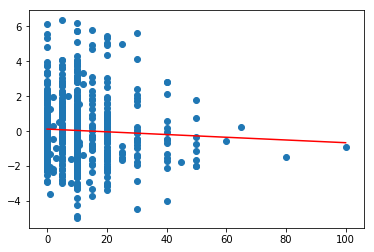

TimeVisualizing


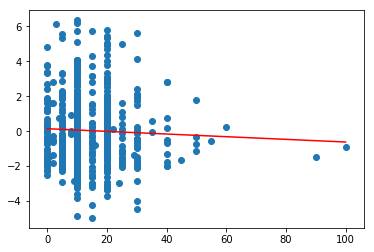

TimeFindingInsights


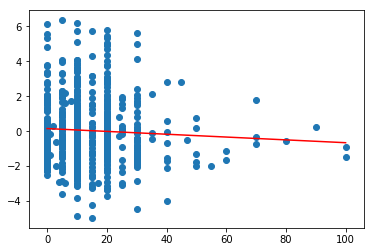

TimeOtherSelect


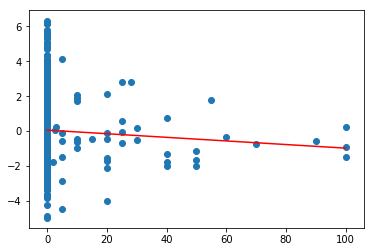

Average Salary Within Country


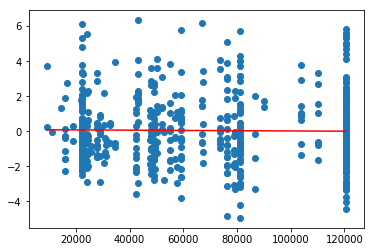

Percent Above/Below Average Salary


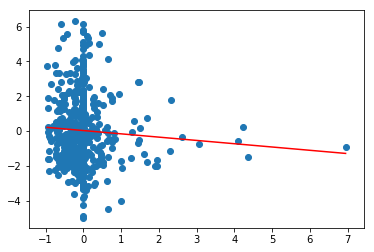

NumberChallenges


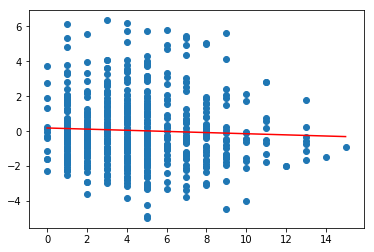

NumberPlatforms


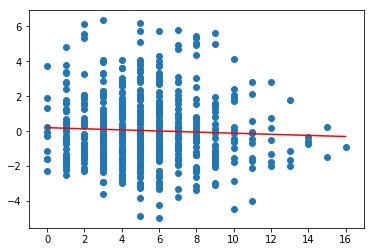

Tools Used At Work Count


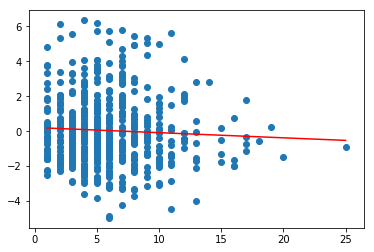

Hardware Types Used


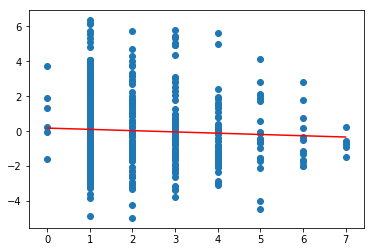

Number of Algorithims


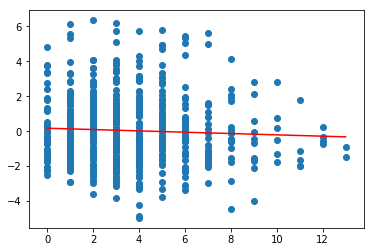

CurrentJobTitleSelect_Data Scientist


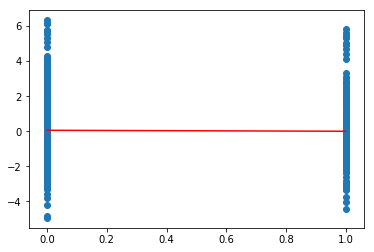

TitleFit_Perfectly


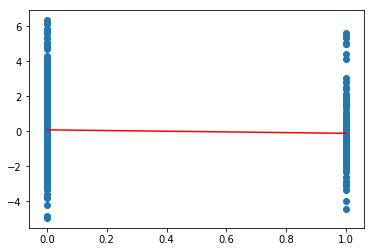

TitleFit_Poorly


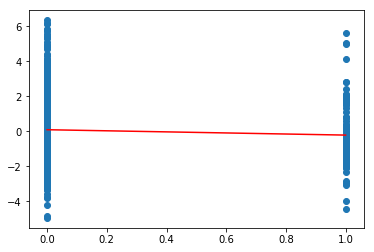

DataScienceIdentitySelect_No


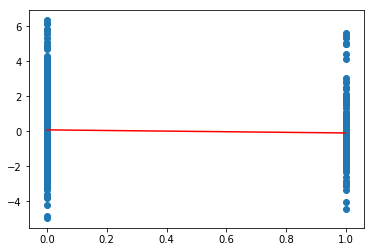

EmployerSizeChange_Increased significantly


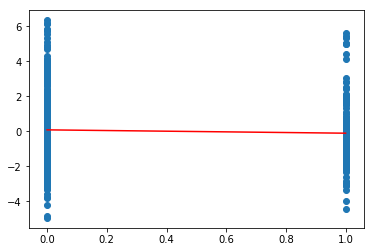

UniversityImportance_Very important


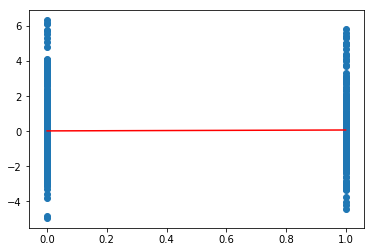

JobFunctionSelect_Analyze and understand data to influence product or business decisions


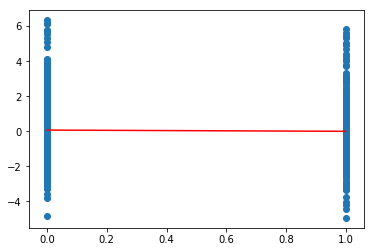

WorkToolsFrequencyJupyter_Never


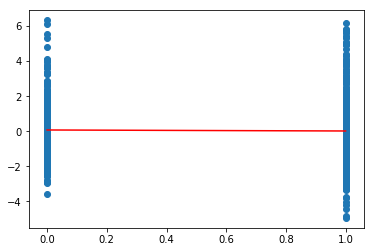

WorkMethodsFrequencyDataVisualization_Most of the time


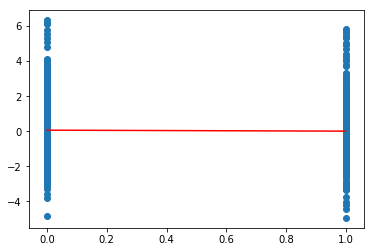

WorkMethodsFrequencyDataVisualization_Never


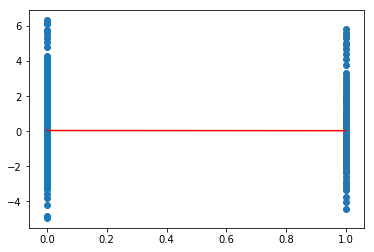

WorkChallengeFrequencyPolitics_Most of the time


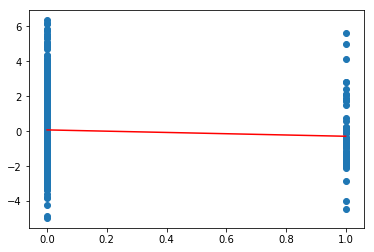

WorkChallengeFrequencyPolitics_Never


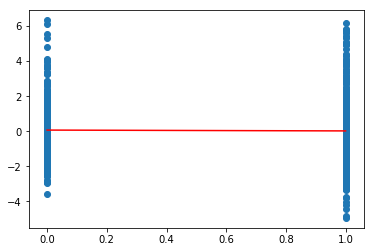

WorkChallengeFrequencyUnusedResults_Never


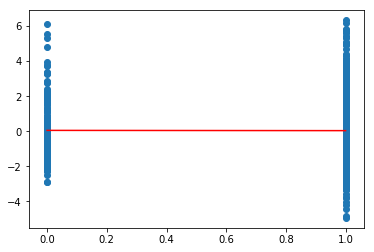

WorkChallengeFrequencyDirtyData_Never


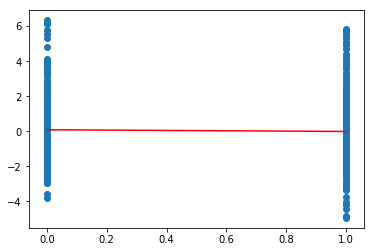

WorkChallengeFrequencyTalent_Most of the time


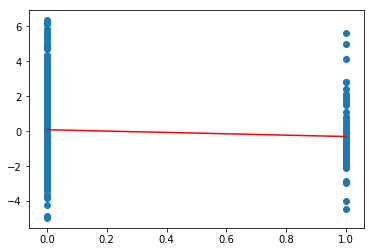

WorkChallengeFrequencyTalent_Never


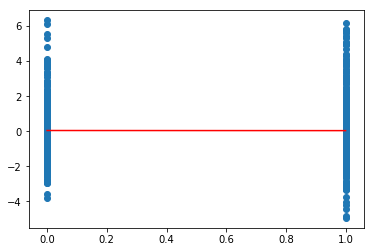

WorkChallengeFrequencyPrivacy_Never


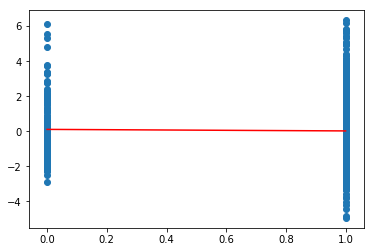

WorkChallengeFrequencyDataAccess_Never


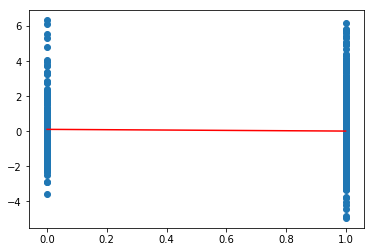

RemoteWork_Never


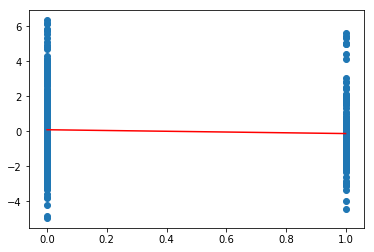

SalaryChange_Has increased 20% or more


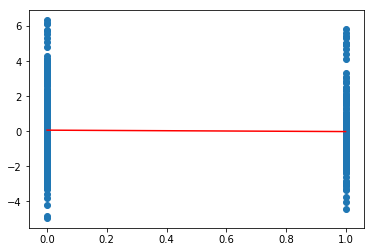

SalaryChange_Has stayed about the same (has not increased or decreased more than 5%)


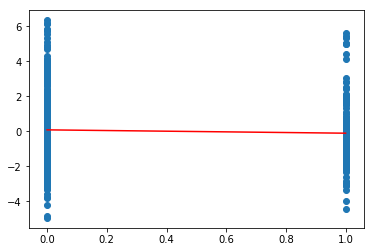

Continent_Asia


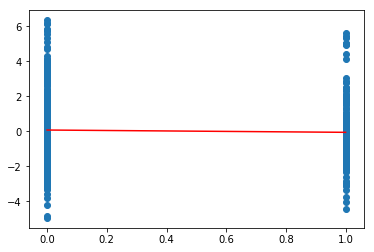

Continent_Other


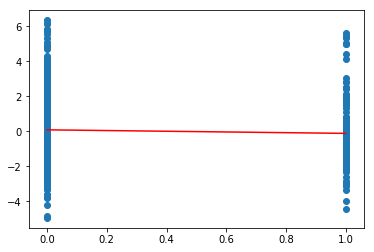

WorkCodeSharing_Git_No


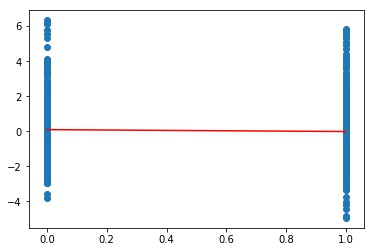

CurrentEmployerType_Employed by a company that doesn't perform advanced analytics_No


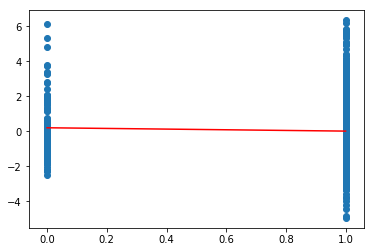

CurrentEmployerType_Employed by a company that doesn't perform advanced analytics_Yes


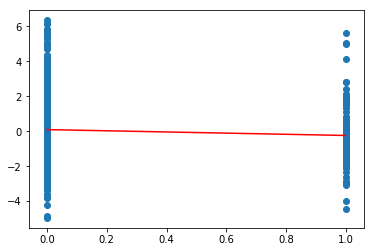

CurrentEmployerType_Employed by a company that performs advanced analytics_No


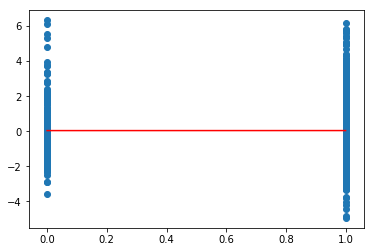

CurrentEmployerType_Employed by a company that performs advanced analytics_Yes


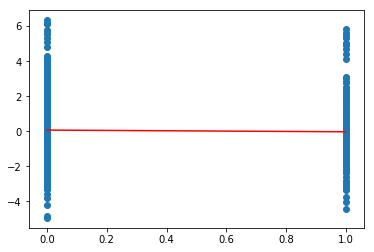

In [21]:
j=221


for i in range(0,len(coef_dict)):
    fig, ax = plt.subplots()
    temp = X_test[list(coef_dict)[i]]
    x = temp.sort_values()
    #print(len(temp.sort_values))
    y=error2
    fit = np.polyfit(x, y, deg=1)
    ax.plot(x, fit[0] * x + fit[1], color='red')
    ax.scatter(x, y)
    print(list(coef_dict)[i])
    plt.show()


In [22]:
feature_importance = est.feature_importances_
feature_length = feature_importance.shape[0]
feature_10 = feature_length-20
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)



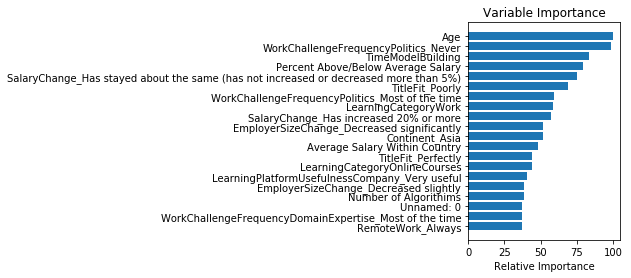

In [23]:
# Plot top 10 features based on importance
feature_importance = est.feature_importances_
feature_length = feature_importance.shape[0]
feature_10 = feature_length-20
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
#sorted_idx=sorted_idx[0:10]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos[feature_10:feature_length], feature_importance[sorted_idx][feature_10:feature_length], align='center')
plt.yticks(pos[feature_10:feature_length], np.array(list(X_train))[sorted_idx][feature_10:feature_length])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [24]:
df['WorkChallengeFrequencyPolitics'].unique()

[Often, Never, Most of the time, Rarely, Sometimes]
Categories (5, object): [Often, Never, Most of the time, Rarely, Sometimes]

In [25]:
df['Age'].quantile([.1,.25,.5,.75,.9])

0.10    25.0
0.25    27.0
0.50    32.0
0.75    39.0
0.90    48.0
Name: Age, dtype: float64

In [26]:
WB = WhiteBoxSensitivity(est,
                    model_df=finaldf,
                    ydepend=dependentVar,
                    cat_df=df,
                    featuredict=None,
                    groupbyvars=['WorkChallengeFrequencyPolitics'],
                    aggregate_func=np.mean,
                    verbose=None,
                     std_num=1
                    )


In [27]:
WB.run()


[{'Type': 'Categorical', 'Change': 'Male', 'Data': [{'GenderSelect': 'A different identity', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.010840623920743772, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'GenderSelect': 'Female', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.015444754918605311, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'GenderSelect': 'A different identity', 'groupByValue': 'Never', 'predictedYSmooth': 0.001971022531044322, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'GenderSelect': 'Female', 'groupByValue': 'Never', 'predictedYSmooth': 0.014897800455356935, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'GenderSelect': 'A different identity', 'groupByValue': 'Often', 'predictedYSmooth': 0.003495445509472993, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'GenderSelect': 'Female', 'groupByValue': 'Often', 'predictedYSmooth': 0.012528019908882299, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'

                                using raw data as opposed to percentile groups.
                                
Group size: (72, 5)


[{'Type': 'Continuous', 'Change': '9.16', 'Data': [{'Age': 22.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.06288202939169844, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Age': 23.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.010398627200037352, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Age': 24.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.006361513110611002, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Age': 25.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.011445223460564615, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Age': 26.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.011161586907325225, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Age': 27.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.01367247146016898, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Age': 28.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.01766868

[{'Type': 'Categorical', 'Change': 'Yes', 'Data': []}]
[{'Type': 'Categorical', 'Change': 'Data Scientist', 'Data': [{'CurrentJobTitleSelect': 'Business Analyst', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0628437601164132, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'CurrentJobTitleSelect': 'Computer Scientist', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.05081031749708057, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'CurrentJobTitleSelect': 'DBA/Database Engineer', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.04191891600227461, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'CurrentJobTitleSelect': 'Data Analyst', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.09027050991184503, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'CurrentJobTitleSelect': 'Data Miner', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.05799024554483031, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Curre

[{'Type': 'Categorical', 'Change': 'TensorFlow', 'Data': [{'MLToolNextYearSelect': 'Amazon Machine Learning', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.04095606057371359, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'MLToolNextYearSelect': 'Amazon Web services', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.032764848458971055, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'MLToolNextYearSelect': 'C/C++', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'MLToolNextYearSelect': 'Cloudera', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'MLToolNextYearSelect': 'DataRobot', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.021843232305980582, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'MLToolNextYearSelect': 'Google Cloud Compute', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.016382

[{'Type': 'Categorical', 'Change': 'Deep learning', 'Data': [{'MLMethodNextYearSelect': 'Anomaly Detection', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'MLMethodNextYearSelect': 'Association Rules', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'MLMethodNextYearSelect': 'Bayesian Methods', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'MLMethodNextYearSelect': 'Cluster Analysis', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'MLMethodNextYearSelect': 'Decision Trees', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'MLMethodNextYearSelect': 'Ensemble Methods (e.g. boosting, bagging)', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, '

[{'Type': 'Categorical', 'Change': 'Python', 'Data': [{'LanguageRecommendationSelect': 'C/C++/C#', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LanguageRecommendationSelect': 'Haskell', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LanguageRecommendationSelect': 'Java', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LanguageRecommendationSelect': 'Julia', 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.05774210857806228, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LanguageRecommendationSelect': 'Matlab', 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.005476922175236283, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LanguageRecommendationSelect': 'Other', 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.010453989066300906, 'grou

[{'Type': 'Categorical', 'Change': 'Very useful', 'Data': [{'LearningPlatformUsefulnessBlogs': 'Not Useful', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.006410601958542743, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningPlatformUsefulnessBlogs': 'Somewhat useful', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0013038512458053487, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningPlatformUsefulnessBlogs': 'Not Useful', 'groupByValue': 'Never', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningPlatformUsefulnessBlogs': 'Somewhat useful', 'groupByValue': 'Never', 'predictedYSmooth': 0.002024400618487252, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningPlatformUsefulnessBlogs': 'Not Useful', 'groupByValue': 'Often', 'predictedYSmooth': 0.007692722350251558, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningPlatformUsefulnessBlogs': 'Somewhat useful', 'groupByValue': 'Oft

[{'Type': 'Categorical', 'Change': 'Somewhat useful', 'Data': [{'LearningPlatformUsefulnessNewsletters': 'Not Useful', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningPlatformUsefulnessNewsletters': 'Very useful', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningPlatformUsefulnessNewsletters': 'Not Useful', 'groupByValue': 'Never', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningPlatformUsefulnessNewsletters': 'Very useful', 'groupByValue': 'Never', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningPlatformUsefulnessNewsletters': 'Not Useful', 'groupByValue': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningPlatformUsefulnessNewsletters': 'Very useful', 'groupByValue': 'Often', 'predictedYSmooth': 0.0, 'groupByVar

[{'Type': 'Categorical', 'Change': 'Very useful', 'Data': [{'LearningPlatformUsefulnessSO': 'Not Useful', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.017369999993946728, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningPlatformUsefulnessSO': 'Somewhat useful', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0390585033165468, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningPlatformUsefulnessSO': 'Not Useful', 'groupByValue': 'Never', 'predictedYSmooth': 0.010016433453786836, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningPlatformUsefulnessSO': 'Somewhat useful', 'groupByValue': 'Never', 'predictedYSmooth': 0.017382734364149024, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningPlatformUsefulnessSO': 'Not Useful', 'groupByValue': 'Often', 'predictedYSmooth': 0.007614422896996764, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningPlatformUsefulnessSO': 'Somewhat useful', 'groupByValue': 'Often',

[{'Type': 'Categorical', 'Change': "Master's degree", 'Data': [{'FormalEducation': "Bachelor's degree", 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.0002756083011478151, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'FormalEducation': 'Doctoral degree', 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.002062946625815682, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'FormalEducation': 'I did not complete any formal education past high school', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'FormalEducation': 'I prefer not to answer', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'FormalEducation': 'Professional degree', 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.0005282492438666456, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'FormalEducation': "Some college/university study without ear

[{'Type': 'Categorical', 'Change': '3 to 5 years', 'Data': [{'Tenure': '1 to 2 years', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Tenure': '6 to 10 years', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.007699946095093228, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Tenure': "I don't write code to analyze data", 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Tenure': 'Less than a year', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Tenure': 'More than 10 years', 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.0010939353782680973, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Tenure': '1 to 2 years', 'groupByValue': 'Never', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Tenure': '6 to 10 years', 'groupBy

                                using raw data as opposed to percentile groups.
                                
Group size: (72, 5)


[{'Type': 'Continuous', 'Change': '24.77', 'Data': [{'LearningCategorySelftTaught': 0.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.032615933193074605, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategorySelftTaught': 5.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.03633225267860141, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategorySelftTaught': 10.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.02166514144019322, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategorySelftTaught': 15.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.03636020806229145, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategorySelftTaught': 20.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.009122102394167494, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategorySelftTaught': 23.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'gro

                                using raw data as opposed to percentile groups.
                                
Group size: (72, 5)


[{'Type': 'Continuous', 'Change': '23.33', 'Data': [{'LearningCategoryOnlineCourses': 0.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0028898942805975977, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryOnlineCourses': 3.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.03568218610324392, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryOnlineCourses': 5.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0034687538207175115, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryOnlineCourses': 10.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.013626499325337375, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryOnlineCourses': 15.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0314441254937341, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryOnlineCourses': 20.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0

                                using raw data as opposed to percentile groups.
                                
Group size: (72, 5)


[{'Type': 'Continuous', 'Change': '19.69', 'Data': [{'LearningCategoryWork': 0.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.10335731432805866, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryWork': 2.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.11655814837558938, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryWork': 5.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.20543174635099065, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryWork': 7.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.3497217402448518, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryWork': 10.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.19389527485784627, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryWork': 15.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.16594823424178845, 'groupByVarName': 'WorkChallengeFrequenc

                                using raw data as opposed to percentile groups.
                                
Group size: (72, 5)


[{'Type': 'Continuous', 'Change': '22.31', 'Data': [{'LearningCategoryUniversity': 0.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0006868547268290855, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryUniversity': 5.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.0011496629936169622, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryUniversity': 10.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.0019028904721935926, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryUniversity': 19.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryUniversity': 20.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryUniversity': 25.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequency

                                using raw data as opposed to percentile groups.
                                
Group size: (72, 5)


[{'Type': 'Continuous', 'Change': '10.22', 'Data': [{'LearningCategoryKaggle': 0.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.05516091304943995, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryKaggle': 1.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.044785151579914535, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryKaggle': 2.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.0756621103675285, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryKaggle': 4.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.02443835420909135, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryKaggle': 5.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.048393528481373155, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryKaggle': 8.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.04624982113870568, 'groupByVarName': 'Wor

                                using raw data as opposed to percentile groups.
                                
Group size: (72, 5)


[{'Type': 'Continuous', 'Change': '7.61', 'Data': [{'LearningCategoryOther': 0.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryOther': 5.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryOther': 10.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryOther': 15.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryOther': 25.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.007663433856272957, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryOther': 37.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'LearningCategoryOther': 100.0, 'groupByValue': 'Most of 

[{'Type': 'Categorical', 'Change': 'Technology', 'Data': [{'EmployerIndustry': 'Academic', 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.007912760610369687, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'EmployerIndustry': 'CRM/Marketing', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'EmployerIndustry': 'Financial', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'EmployerIndustry': 'Government', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'EmployerIndustry': 'Hospitality/Entertainment/Sports', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'EmployerIndustry': 'Insurance', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Employe

[{'Type': 'Categorical', 'Change': '10,000 or more employees', 'Data': [{'EmployerSize': '1,000 to 4,999 employees', 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.011708016587648699, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'EmployerSize': '10 to 19 employees', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.07283520054916798, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'EmployerSize': '100 to 499 employees', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.00901316747884606, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'EmployerSize': '20 to 99 employees', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.03595525892151025, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'EmployerSize': '5,000 to 9,999 employees', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.03323143548000669, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'EmployerSize': '500 to 999 employees', 'groupByValue': 'Most of t

[{'Type': 'Categorical', 'Change': '3-5 years', 'Data': [{'EmployerMLTime': '1-2 years', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'EmployerMLTime': '6-10 years', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'EmployerMLTime': 'Less than one year', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'EmployerMLTime': 'Missing', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.009401035546633164, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'EmployerMLTime': 'More than 10 years', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'EmployerMLTime': '1-2 years', 'groupByValue': 'Never', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'EmployerMLTime': '6-10 years', 'groupByVal

[{'Type': 'Categorical', 'Change': 'Very important', 'Data': [{'UniversityImportance': 'Important', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.2507829911469489, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'UniversityImportance': 'N/A, I did not receive any formal education', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.2552858993721611, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'UniversityImportance': 'Not at all important', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.31080818456520215, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'UniversityImportance': 'Not very important', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.2533014033686123, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'UniversityImportance': 'Somewhat important', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.2729158178657539, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'UniversityImportance': 'Important', '

[{'Type': 'Categorical', 'Change': 'Relational data', 'Data': [{'groupByValue': 'Most of the time', 'WorkDataTypeSelect': 'Image data', 'predictedYSmooth': 0.009315026605565057, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkDataTypeSelect': 'Image data,Other', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkDataTypeSelect': 'Image data,Relational data', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkDataTypeSelect': 'Image data,Text data', 'predictedYSmooth': 0.03680129797142531, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkDataTypeSelect': 'Image data,Text data,Relational data', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkDataTypeSelect': 'Image data,Text data,Relational

[{'Type': 'Categorical', 'Change': 'Sometimes', 'Data': [{'groupByValue': 'Most of the time', 'WorkProductionFrequency': 'Always', 'predictedYSmooth': -0.0075639142808781035, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkProductionFrequency': 'Missing', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkProductionFrequency': 'Most of the time', 'predictedYSmooth': -0.035641046290325565, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkProductionFrequency': 'Never', 'predictedYSmooth': 0.006669358464762156, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkProductionFrequency': 'Rarely', 'predictedYSmooth': 0.04146741168289359, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkProductionFrequency': 'Always', 'predictedYSmooth': -0.01578506208207956

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkToolsFrequencyAmazonML': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyAmazonML': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyAmazonML': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyAmazonML': 'Sometimes', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyAmazonML': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyAmazonML': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': '

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkToolsFrequencyCloudera': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyCloudera': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyCloudera': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyCloudera': 'Sometimes', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyCloudera': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyCloudera': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': '

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkToolsFrequencyHadoop': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyHadoop': 'Often', 'predictedYSmooth': 0.010921993617976826, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyHadoop': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyHadoop': 'Sometimes', 'predictedYSmooth': 0.01034933130642821, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyHadoop': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyHadoop': 'Often', 'predictedYSmooth': 0.0077632943742994825, 'groupByVarName': 'WorkChallenge

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkToolsFrequencyIBMSPSSStatistics': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyIBMSPSSStatistics': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyIBMSPSSStatistics': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyIBMSPSSStatistics': 'Sometimes', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyIBMSPSSStatistics': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyIBMSPSSStatistics': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName':

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkToolsFrequencyImpala': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyImpala': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyImpala': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyImpala': 'Sometimes', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyImpala': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyImpala': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'Wor

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkToolsFrequencyJulia': 'Most of the time', 'predictedYSmooth': -0.1377108946441723, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyJulia': 'Often', 'predictedYSmooth': -0.011966398145721868, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyJulia': 'Rarely', 'predictedYSmooth': -0.047748514520286944, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyJulia': 'Sometimes', 'predictedYSmooth': -0.09143851869915154, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyJulia': 'Most of the time', 'predictedYSmooth': -0.07110450493143175, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyJulia': 'Often', 'predictedYSmooth': -0.07033

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkToolsFrequencyKNIMEFree': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyKNIMEFree': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyKNIMEFree': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyKNIMEFree': 'Sometimes', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyKNIMEFree': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyKNIMEFree': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByVal

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkToolsFrequencyAzure': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyAzure': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyAzure': 'Rarely', 'predictedYSmooth': -0.03558578826946939, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyAzure': 'Sometimes', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyAzure': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyAzure': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'N

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkToolsFrequencyMicrosoftSQL': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyMicrosoftSQL': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyMicrosoftSQL': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyMicrosoftSQL': 'Sometimes', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyMicrosoftSQL': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyMicrosoftSQL': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPoliti

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkToolsFrequencyOracle': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyOracle': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyOracle': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyOracle': 'Sometimes', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyOracle': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyOracle': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'Wor

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkToolsFrequencyQlik': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyQlik': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyQlik': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyQlik': 'Sometimes', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyQlik': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyQlik': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFreque

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkToolsFrequencySalfrod': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencySalfrod': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencySalfrod': 'Sometimes', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencySalfrod': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencySalfrod': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencySalfrod': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequency

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkToolsFrequencySASJMP': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencySASJMP': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencySASJMP': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencySASJMP': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencySASJMP': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencySASJMP': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequenc

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkToolsFrequencyStan': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyStan': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyStan': 'Sometimes', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyStan': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyStan': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyStan': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyStan': 'Sometimes'

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkToolsFrequencyTIBCO': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyTIBCO': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyTIBCO': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencyTIBCO': 'Sometimes', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyTIBCO': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencyTIBCO': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkTools

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkToolsFrequencySelect2': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencySelect2': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencySelect2': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkToolsFrequencySelect2': 'Sometimes', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencySelect2': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkToolsFrequencySelect2': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never'

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkMethodsFrequencyAssociationRules': 'Most of the time', 'predictedYSmooth': -0.002142818526308677, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyAssociationRules': 'Often', 'predictedYSmooth': -0.0031676447780215225, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyAssociationRules': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyAssociationRules': 'Sometimes', 'predictedYSmooth': -0.0018213957473623755, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkMethodsFrequencyAssociationRules': 'Most of the time', 'predictedYSmooth': -0.005519381052613259, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkMethod

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkMethodsFrequencyCollaborativeFiltering': 'Most of the time', 'predictedYSmooth': -0.01049035862264116, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyCollaborativeFiltering': 'Often', 'predictedYSmooth': -0.01413124361071052, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyCollaborativeFiltering': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyCollaborativeFiltering': 'Sometimes', 'predictedYSmooth': -0.010038824446496862, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkMethodsFrequencyCollaborativeFiltering': 'Most of the time', 'predictedYSmooth': -0.015001879642455414, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByVa

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkMethodsFrequencyDecisionTrees': 'Most of the time', 'predictedYSmooth': 0.0010954892735556044, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyDecisionTrees': 'Often', 'predictedYSmooth': 0.002165794885650171, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyDecisionTrees': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyDecisionTrees': 'Sometimes', 'predictedYSmooth': 0.0014875591188281364, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkMethodsFrequencyDecisionTrees': 'Most of the time', 'predictedYSmooth': 0.0018735356326149875, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkMethodsFrequencyDecision

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkMethodsFrequencyGANs': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyGANs': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyGANs': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyGANs': 'Sometimes', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkMethodsFrequencyGANs': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkMethodsFrequencyGANs': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'Wor

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkMethodsFrequencyKNN': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyKNN': 'Often', 'predictedYSmooth': -0.020969948436828336, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyKNN': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyKNN': 'Sometimes', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkMethodsFrequencyKNN': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkMethodsFrequencyKNN': 'Often', 'predictedYSmooth': -0.012960443384486528, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, 

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkMethodsFrequencyMLN': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyMLN': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyMLN': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyMLN': 'Sometimes', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkMethodsFrequencyMLN': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkMethodsFrequencyMLN': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkMetho

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkMethodsFrequencyNeuralNetworks': 'Most of the time', 'predictedYSmooth': -0.015374751102765141, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyNeuralNetworks': 'Often', 'predictedYSmooth': -0.01346300060965223, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyNeuralNetworks': 'Rarely', 'predictedYSmooth': -0.07570492721377363, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyNeuralNetworks': 'Sometimes', 'predictedYSmooth': -0.012258483171968298, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkMethodsFrequencyNeuralNetworks': 'Most of the time', 'predictedYSmooth': -0.019880795964312952, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkMe

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkMethodsFrequencyRandomForests': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyRandomForests': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyRandomForests': 'Rarely', 'predictedYSmooth': 0.022650794626583762, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyRandomForests': 'Sometimes', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkMethodsFrequencyRandomForests': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkMethodsFrequencyRandomForests': 'Often', 'predictedYSmooth': 0.0, 'groupByVarN

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkMethodsFrequencySegmentation': 'Most of the time', 'predictedYSmooth': -0.07950596998786356, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencySegmentation': 'Often', 'predictedYSmooth': -0.0063797685070177855, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencySegmentation': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencySegmentation': 'Sometimes', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkMethodsFrequencySegmentation': 'Most of the time', 'predictedYSmooth': -0.08663521663992528, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkMethodsFrequencySegmentation': 'Often', 'predic

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkMethodsFrequencyTextAnalysis': 'Most of the time', 'predictedYSmooth': -0.02229493047498201, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyTextAnalysis': 'Often', 'predictedYSmooth': -0.02551121983595309, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyTextAnalysis': 'Rarely', 'predictedYSmooth': -0.03306239009537978, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMethodsFrequencyTextAnalysis': 'Sometimes', 'predictedYSmooth': -0.024712593823381812, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkMethodsFrequencyTextAnalysis': 'Most of the time', 'predictedYSmooth': -0.020556540715013085, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkMethodsFreque

                                using raw data as opposed to percentile groups.
                                
Group size: (72, 5)


[{'Type': 'Continuous', 'Change': '21.33', 'Data': [{'TimeGatheringData': 0.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.005100488468960294, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeGatheringData': 1.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.011538785405033725, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeGatheringData': 5.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.01898671620429178, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeGatheringData': 8.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.05399080407515733, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeGatheringData': 10.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.02574429992885995, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeGatheringData': 15.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.02055317504871068, 'groupByVarName': 'WorkChallengeFrequencyPolitics

                                using raw data as opposed to percentile groups.
                                
Group size: (72, 5)


[{'Type': 'Continuous', 'Change': '15.77', 'Data': [{'TimeModelBuilding': 0.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.10737339972878022, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeModelBuilding': 1.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.022429914951955194, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeModelBuilding': 3.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.06067164485812815, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeModelBuilding': 5.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.014426306416638557, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeModelBuilding': 6.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeModelBuilding': 10.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.009755355113297967, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeModelBuildin

                                using raw data as opposed to percentile groups.
                                
Group size: (72, 5)


[{'Type': 'Continuous', 'Change': '12.15', 'Data': [{'TimeProduction': 0.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.036060290511408875, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeProduction': 2.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.04458072865560814, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeProduction': 3.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.05666992601981787, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeProduction': 5.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.04443170072480288, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeProduction': 8.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.02989457517397298, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeProduction': 10.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.03490903645697523, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeProduction': 15.

                                using raw data as opposed to percentile groups.
                                
Group size: (72, 5)


[{'Type': 'Continuous', 'Change': '11.56', 'Data': [{'TimeVisualizing': 0.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.003380407030147405, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeVisualizing': 1.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeVisualizing': 3.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.022406014501635214, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeVisualizing': 5.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.001235395105562089, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeVisualizing': 10.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeVisualizing': 15.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeVisualizing': 20.0, 'groupByValue': 'Most of the time

                                using raw data as opposed to percentile groups.
                                
Group size: (72, 5)


[{'Type': 'Continuous', 'Change': '12.6', 'Data': [{'TimeFindingInsights': 0.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.05979099355845236, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeFindingInsights': 1.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.05672356534921441, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeFindingInsights': 2.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.05703666252356343, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeFindingInsights': 3.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.04145077347192849, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeFindingInsights': 5.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.03046221502867067, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeFindingInsights': 6.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.07114581295677369, 'groupByVarName': 'WorkChallengeFrequencyPolitic

                                using raw data as opposed to percentile groups.
                                
Group size: (72, 5)


[{'Type': 'Continuous', 'Change': '12.19', 'Data': [{'TimeOtherSelect': 0.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeOtherSelect': 5.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeOtherSelect': 10.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeOtherSelect': 25.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeOtherSelect': 30.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeOtherSelect': 50.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'TimeOtherSelect': 65.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'Work

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'WorkChallengeFrequencyDeployment': 'Most of the time', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyDeployment': 'Often', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyDeployment': 'Rarely', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyDeployment': 'Sometimes', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyDeployment': 'Most of the time', 'groupByValue': 'Never', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyDeployment': 'Often', 'groupByValue': 'Never', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFre

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'WorkChallengeFrequencyPass': 'Most of the time', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyPass': 'Sometimes', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyPass': 'Most of the time', 'groupByValue': 'Never', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyPass': 'Often', 'groupByValue': 'Never', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyPass': 'Rarely', 'groupByValue': 'Never', 'predictedYSmooth': -0.035863262520612574, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyPass': 'Sometimes', 'groupByValue': 'Never', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFre

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'WorkChallengeFrequencyDataFunds': 'Most of the time', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.05931180317646735, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyDataFunds': 'Often', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyDataFunds': 'Rarely', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyDataFunds': 'Sometimes', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyDataFunds': 'Most of the time', 'groupByValue': 'Never', 'predictedYSmooth': 0.05162611187102602, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyDataFunds': 'Often', 'groupByValue': 'Never', 'predictedYSmooth': 0.0, 'groupByV

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'groupByValue': 'Most of the time', 'WorkChallengeFrequencyTools': 'Most of the time', 'predictedYSmooth': 0.22989635829459965, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkChallengeFrequencyTools': 'Often', 'predictedYSmooth': 0.023843951234662746, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkChallengeFrequencyTools': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkChallengeFrequencyTools': 'Sometimes', 'predictedYSmooth': 0.0075894565441718175, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkChallengeFrequencyTools': 'Most of the time', 'predictedYSmooth': 0.26654910800651427, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkChallengeFrequencyTools': 'Often', 'predictedYSmooth': 0.0

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'WorkChallengeFrequencyHiringFunds': 'Most of the time', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0538241157461726, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyHiringFunds': 'Often', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyHiringFunds': 'Rarely', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyHiringFunds': 'Sometimes', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyHiringFunds': 'Most of the time', 'groupByValue': 'Never', 'predictedYSmooth': 0.06260245265523928, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyHiringFunds': 'Often', 'groupByValue': 'Never', 'predictedYSmooth': 0.0

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'WorkChallengeFrequencyEnvironments': 'Most of the time', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyEnvironments': 'Often', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyEnvironments': 'Rarely', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyEnvironments': 'Sometimes', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyEnvironments': 'Most of the time', 'groupByValue': 'Never', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyEnvironments': 'Often', 'groupByValue': 'Never', 'predictedYSmooth': 0.0, 'groupByVarName': 'Work

[{'Type': 'Categorical', 'Change': 'Never', 'Data': [{'WorkChallengeFrequencyOtherSelect': 'Most of the time', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyOtherSelect': 'Often', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyOtherSelect': 'Most of the time', 'groupByValue': 'Never', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyOtherSelect': 'Often', 'groupByValue': 'Never', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyOtherSelect': 'Rarely', 'groupByValue': 'Never', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'WorkChallengeFrequencyOtherSelect': 'Sometimes', 'groupByValue': 'Never', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}

[{'Type': 'Categorical', 'Change': 'Standalone Team', 'Data': [{'groupByValue': 'Most of the time', 'WorkMLTeamSeatSelect': 'Business Department', 'predictedYSmooth': -0.00061321555723148, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMLTeamSeatSelect': 'Central Insights Team', 'predictedYSmooth': -0.0014162359297964922, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMLTeamSeatSelect': 'IT Department', 'predictedYSmooth': 0.026623751343046228, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'WorkMLTeamSeatSelect': 'Other', 'predictedYSmooth': -0.00015612049619804084, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkMLTeamSeatSelect': 'Business Department', 'predictedYSmooth': -0.0006887896829779636, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Never', 'WorkMLTeamSeatSelect': 'Central Insig

                                using raw data as opposed to percentile groups.
                                
Group size: (72, 5)


[{'Type': 'Continuous', 'Change': '9.04', 'Data': [{'Unnamed: 0': 1.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.028188167551334225, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Unnamed: 0': 2.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.014506119879090371, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Unnamed: 0': 3.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.009618547505713535, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Unnamed: 0': 4.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.015557396926668687, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Unnamed: 0': 5.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.005884190112522412, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Unnamed: 0': 6.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.010787681872957755, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Unnamed: 0': 6.835740072202166, 'groupByV

[{'Type': 'Categorical', 'Change': 'USD', 'Data': [{'groupByValue': 'Most of the time', 'originCountry': 'AED', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'originCountry': 'ARS', 'predictedYSmooth': -0.009817976054425692, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'originCountry': 'AUD', 'predictedYSmooth': -0.004207704023325424, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'originCountry': 'BDT', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'originCountry': 'BRL', 'predictedYSmooth': -0.0649941615396481, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'originCountry': 'CAD', 'predictedYSmooth': -0.00163632934240443, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'groupByValue': 'Most of the time', 'originCo

                                using raw data as opposed to percentile groups.
                                
Group size: (72, 5)


[{'Type': 'Continuous', 'Change': '38345.49', 'Data': [{'Average Salary Within Country': 14565.575555555557, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.06554926612229621, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Average Salary Within Country': 16646.548571428568, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.10394087596787736, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Average Salary Within Country': 22056.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.17791570012204208, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Average Salary Within Country': 22093.044625380695, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.12485628127873041, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Average Salary Within Country': 22632.284, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Average Salary Within Country': 24013.585196689648, 'groupB

                                using raw data as opposed to percentile groups.
                                
Group size: (72, 5)


[{'Type': 'Continuous', 'Change': '0.63', 'Data': [{'Percent Above/Below Average Salary': -0.953690637007528, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.03258375204367573, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Percent Above/Below Average Salary': -0.9311358841328214, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.05979758997335235, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Percent Above/Below Average Salary': -0.8542590167843773, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.06741028412095702, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Percent Above/Below Average Salary': -0.7878970472627083, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.049164859532202364, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Percent Above/Below Average Salary': -0.7568210505353196, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.11217603710862682, 'groupByVarName': 'WorkChallengeFrequencyPolitics'},

                                using raw data as opposed to percentile groups.
                                
Group size: (72, 5)


[{'Type': 'Continuous', 'Change': '2.91', 'Data': [{'NumberChallenges': 1, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.008742850113939363, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'NumberChallenges': 2, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.0010321420273400575, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'NumberChallenges': 3, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.007633455267577467, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'NumberChallenges': 4, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0020117972045218652, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'NumberChallenges': 5, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.013606953346893401, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'NumberChallenges': 6, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.02178593522543812, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'NumberChallen

                                using raw data as opposed to percentile groups.
                                
Group size: (72, 5)


[{'Type': 'Continuous', 'Change': '2.94', 'Data': [{'NumberPlatforms': 0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.05412591977573327, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'NumberPlatforms': 1, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.05628541909507703, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'NumberPlatforms': 2, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.013994088088858414, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'NumberPlatforms': 3, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.00187318397280383, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'NumberPlatforms': 4, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.001344850031756596, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'NumberPlatforms': 5, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0029705205079212874, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'NumberPlatforms': 6, 'gro

[{'Type': 'Categorical', 'Change': 'No', 'Data': [{'MLSkillsSelect_Adversarial Learning': 'Yes', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'MLSkillsSelect_Adversarial Learning': 'Yes', 'groupByValue': 'Never', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'MLSkillsSelect_Adversarial Learning': 'Yes', 'groupByValue': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'MLSkillsSelect_Adversarial Learning': 'Yes', 'groupByValue': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'MLSkillsSelect_Adversarial Learning': 'Yes', 'groupByValue': 'Sometimes', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}]}]
[{'Type': 'Categorical', 'Change': 'No', 'Data': [{'MLSkillsSelect_Computer Vision': 'Yes', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.004292489099206993, 'groupByVarN

[{'Type': 'Categorical', 'Change': 'No', 'Data': [{'MLSkillsSelect_Time Series': 'Yes', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'MLSkillsSelect_Time Series': 'Yes', 'groupByValue': 'Never', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'MLSkillsSelect_Time Series': 'Yes', 'groupByValue': 'Often', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'MLSkillsSelect_Time Series': 'Yes', 'groupByValue': 'Rarely', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'MLSkillsSelect_Time Series': 'Yes', 'groupByValue': 'Sometimes', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}]}]
[{'Type': 'Categorical', 'Change': 'No', 'Data': [{'MLSkillsSelect_Unsupervised Learning': 'Yes', 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.000851414770537602, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}

                                using raw data as opposed to percentile groups.
                                
Group size: (72, 5)


[{'Type': 'Continuous', 'Change': '3.43', 'Data': [{'Tools Used At Work Count': 1.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.11874976401207542, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Tools Used At Work Count': 2.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.1439643510824192, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Tools Used At Work Count': 3.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0431983042164284, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Tools Used At Work Count': 4.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0075235729490641095, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Tools Used At Work Count': 5.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.011506989922383543, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'Tools Used At Work Count': 6.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.015641503869223056, 'groupByVarName'

                                using raw data as opposed to percentile groups.
                                
Group size: (72, 5)


[{'Type': 'Continuous', 'Change': '1.68', 'Data': [{'ML Skill Count': 0.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'ML Skill Count': 1.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.00863595800135858, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'ML Skill Count': 2.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': -0.006280331671611196, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'ML Skill Count': 3.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'ML Skill Count': 4.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'ML Skill Count': 5.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, 'groupByVarName': 'WorkChallengeFrequencyPolitics'}, {'ML Skill Count': 6.0, 'groupByValue': 'Most of the time', 'predictedYSmooth': 0.0, '

error: unbalanced parenthesis at position 27

In [345]:
 np.array(list(xTrain))[sorted_idx][feature_10:feature_length]

array(['CurrentJobTitleSelect_Data Scientist',
       'LearningCategoryOnlineCourses',
       'Employed by a company that performs advanced analytics_Yes',
       'Employed by a company that performs advanced analytics_No',
       'UniversityImportance_Very important',
       'WorkChallengeFrequencyTalent_Most of the time',
       'LearningPlatformUsefulnessConferences_Missing',
       'TimeModelBuilding', 'WorkChallengeFrequencyPolitics_Often',
       'RemoteWork_Never', 'AlgorithmUnderstandingLevel_Beginner',
       'EmployerSizeChange_Decreased significantly',
       'SalaryChange_Has stayed about the same (has not increased or decreased more than 5%)',
       'SalaryChange_Has increased 20% or more',
       'DataScienceIdentitySelect_No', 'LearningCategoryWork',
       'Continent_Asia', 'Number of Algorithims',
       'WorkChallengeFrequencyPolitics_Most of the time',
       'WorkChallengeFrequencyPolitics_Never'], 
      dtype='<U132')

In [ ]:
#feature dictionary for when the dependent variable is continuous 
FeatureDict_continuous = {'WorkChallengeFrequencyPolitics' : 'Frequency of Political Work Issues', 
                'Number of Algorithims' : 'Number of Algorithims',
               'SalaryChange' : 'Salary Change',
               'LearningCategoryWork' : 'Proportion of Knowledge Gained From Work',
               'LearningCategoryOnlineCourses' : 'Proportion of Knowledge Gained From Online Courses',
               'DataScienceIdentitySelect' : 'Views Self As Data Scientist',
               'RemoteWork' : 'Remote Work',
               'Employed by a company that performs advanced analytics' : 'Employed by a company that performs advanced analytics',
               'TimeModelBuilding' : 'Proportion of Time Spent Model Building'
              }


#with featureDict
sensitivity_plot(data=final_data,dependentVar=dependentVar, 
                 modelObject=Rf,
                  ouputPath = outputPath,chartTitle= dependentVar.title() , groupByVar =['AlgorithmUnderstandingLevel'],
                 featureDict = FeatureDict_continuous)

0
1
2
3


In [43]:
disp_cat=['DataScienceIdentitySelect']
xTestData=final_data
for k in range(0,len(disp_cat)):
    print(k)
    f = disp_cat[k]

    syntheticXData  = xTestData[varList]
    #incremental change using the cat_incremental value
    for elem in data[disp_cat[k]].unique():
            if(elem == cat_incrementalVal[k]):
                syntheticXData[disp_cat[k]+'_'+str(elem)] = 1
            else:
                syntheticXData[disp_cat[k]+'_'+str(elem)] = 0
    predictedYData[f] = modelObject.predict(syntheticXData)
    #calculate sensitivity
    sensitivity = predictedYData[f] - yTestData.tolist()
    predictedYSmooth= []
    independentVarPlot = []
    groupByVarPlot = []
    groupByVarName = []
    syntheticXData[f] = data[disp_cat[k]]

    for y in range(0,len(groupByVar)):
        for l in data[groupByVar[y]].unique():
            #get the indices, where this groupByVar is equal to this level
            ind = data[data[groupByVar[y]] == l].index.tolist()
            predictedYDataSubset = sensitivity.ix[ind]
            syntheticXDataSubset = syntheticXData.ix[ind]
            #Iterate for eac unique value of ategorical independent variable
            for m in syntheticXDataSubset[disp_cat[k]].unique():
                #if level m is equal to cat_incremental value for this variable, then skip
                if m == cat_incrementalVal[k]:
                    continue
                #get the indices where this categorical independent variable is equal to this unique value
                ind_cat = syntheticXDataSubset[syntheticXDataSubset[f] == m].index.tolist()
                predictedYSmooth.extend([predictedYDataSubset.ix[ind_cat].mean()])
                #append unique value of categorical independent variable
                independentVarPlot.extend([m])
                #append level of groupby variable
                groupByVarPlot.extend([l])
                #append groupby variable
                groupByVarName.extend([groupByVar[y]])

(5199, 577)

In [44]:
len(cont_independentVar)

106

In [56]:
set(xTrain.columns) - set(cat_dummy.columns) - set(cont_independentVar) - set()

{'index'}

,Age,LearningCategorySelftTaught,LearningCategoryOnlineCourses,LearningCategoryWork,LearningCategoryUniversity,LearningCategoryKaggle,LearningCategoryOther,EmployerSizeChange,WorkProductionFrequency,WorkToolsFrequencyAmazonML,...,Employed by company that makes advanced analytic software_No,Employed by company that makes advanced analytic software_Yes,Employed by government_No,Employed by government_Yes,Employed by non-profit or NGO_No,Employed by non-profit or NGO_Yes,Employed by professional services/consulting firm_No,Employed by professional services/consulting firm_Yes,Self-employed_No,Self-employed_Yes
0,35.000000,40.0,0.0,0.0,50.0,10.0,0.0,3.723447,3.043389,2.893773,...,1,0,0,1,1,0,1,0,1,0
1,43.000000,70.0,0.0,30.0,0.0,0.0,0.0,4.000000,2.000000,2.893773,...,1,0,1,0,0,1,1,0,1,0
2,33.000000,10.0,70.0,15.0,0.0,5.0,0.0,3.000000,3.000000,2.893773,...,1,0,1,0,1,0,1,0,1,0
3,27.000000,10.0,0.0,30.0,40.0,0.0,20.0,5.000000,4.000000,2.893773,...,1,0,1,0,1,0,0,1,1,0
4,26.000000,50.0,50.0,0.0,0.0,0.0,0.0,3.000000,3.000000,2.893773,...,1,0,1,0,1,0,0,1,1,0
5,33.000000,10.0,30.0,0.0,10.0,50.0,0.0,4.000000,1.000000,2.893773,...,1,0,1,0,1,0,0,1,1,0
6,34.202557,0.0,50.0,25.0,0.0,0.0,25.0,4.000000,2.000000,2.893773,...,1,0,1,0,1,0,1,0,1,0
7,51.000000,30.0,15.0,35.0,20.0,0.0,0.0,4.000000,5.000000,2.893773,...,1,0,1,0,1,0,1,0,1,0
8,34.000000,20.0,30.0,50.0,0.0,0.0,0.0,5.000000,3.000000,2.893773,...,1,0,1,0,1,0,1,0,1,0
9,53.000000,40.0,10.0,50.0,0.0,0.0,0.0,3.000000,4.000000,2.893773,...,0,1,1,0,1,0,0,1,1,0


In [ ]:
########################
# Need to go in here and try out class probabilities 

In [173]:
groupByVar =['Continent']
data = final_data
data = data.reset_index()
yTestData= data['JobSatisfaction']
predictedYData= data['JobSatisfaction']
f=0
for y in range(0,len(groupByVar)):
    for l in data[groupByVar[y]].unique():
        ind = data[data[groupByVar[y]] == l].index.tolist()
        grouplevel.extend([l])
        groupvar.extend([groupByVar[y]])               
        counts.append(len(data[data[groupByVar[y]] == l]))
        predictedYData[f].iloc[ind]

AttributeError: 'numpy.int64' object has no attribute 'iloc'

,index,Unnamed: 0,GenderSelect,Age,EmploymentStatus,CodeWriter,CurrentJobTitleSelect,TitleFit,MLToolNextYearSelect,MLMethodNextYearSelect,...,Subversion,Number of Code Sharing Methods,Employed by a company that doesn't perform advanced analytics,Employed by a company that performs advanced analytics,Employed by college or university,Employed by company that makes advanced analytic software,Employed by government,Employed by non-profit or NGO,Employed by professional services/consulting firm,Self-employed
0,2,2,Male,35.000000,Employed full-time,Yes,Computer Scientist,Fine,TensorFlow,Text Mining,...,No,2.0,No,No,No,No,Yes,No,No,No
1,3,3,Female,43.000000,Employed full-time,Yes,Business Analyst,Fine,Microsoft Excel Data Mining,Link Analysis,...,No,1.0,No,No,No,No,No,Yes,No,No
2,4,4,Male,33.000000,Employed full-time,Yes,Software Developer/Software Engineer,Fine,C/C++,Deep learning,...,No,2.0,Yes,No,No,No,No,No,No,No
3,5,5,Male,27.000000,Employed full-time,Yes,Data Scientist,Fine,Other,Deep learning,...,No,1.0,No,Yes,No,No,No,No,Yes,No
4,6,6,Male,26.000000,Employed full-time,Yes,Software Developer/Software Engineer,Fine,TensorFlow,Deep learning,...,No,1.0,No,No,No,No,No,No,Yes,No
5,7,7,Male,33.000000,Employed full-time,Yes,Scientist/Researcher,Perfectly,R,Deep learning,...,No,2.0,No,No,No,No,No,No,Yes,No
6,8,8,Male,34.202557,Employed full-time,Yes,Software Developer/Software Engineer,Fine,Spark / MLlib,Deep learning,...,No,2.0,No,Yes,No,No,No,No,No,No
7,10,10,Male,51.000000,Employed full-time,Yes,Engineer,Poorly,I don't plan on learning a new tool/technology,I don't plan on learning a new ML/DS method,...,No,1.0,Yes,No,No,No,No,No,No,No
8,11,11,Male,34.000000,Employed full-time,Yes,Data Scientist,Fine,Spark / MLlib,"Ensemble Methods (e.g. boosting, bagging)",...,No,1.0,Yes,No,No,No,No,No,No,No
9,12,12,Male,53.000000,Employed full-time,Yes,Business Analyst,Fine,Missing,Proprietary Algorithms,...,No,1.0,No,Yes,No,Yes,No,No,Yes,No


In [ ]:
#insert call to error plot here 

#insert real call to sensitivity plot here
print(sensitivity_plot(X_test.join(y_test),'JobSatisfaction',cont_independentVar,cat_independentVar,
                               Rf,ouputPath,'Data Scienctist Job Satisfaction',['Continent', 'WorkChallengeFrequencyPolitics']))

In [ ]:
#seeing if we get a differnet result for a classifier

y_train_binary = np.where(y_train < y_train.mean() , 1, 0)
y_test_binary = np.where(y_test < y_train.mean() , 1, 0)

modelObject = GradientBoostingClassifier(n_estimators=500,   max_features = 'sqrt', learning_rate=.01)
modelObject.fit(X_train,y_train_binary)
y_in_pred = modelObject.predict(X_train)
y_out_pred=modelObject.predict(X_test)
print(accuracy_score(y_train_binary, y_in_pred)) 
print(accuracy_score(y_test_binary, y_out_pred))  

# Plot top 10 feature importance
feature_importance = modelObject.feature_importances_
feature_length = feature_importance.shape[0]
feature_10 = feature_length-15
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
#sorted_idx=sorted_idx[0:10]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos[feature_10:feature_length], feature_importance[sorted_idx][feature_10:feature_length], align='center')
plt.yticks(pos[feature_10:feature_length], np.array(list(X_train))[sorted_idx][feature_10:feature_length])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
#feature dictionary for when the dependent variable is binary

FeatureDict = {'WorkChallengeFrequencyPolitics' : 'Frequency of Political Work Issues', 
               'WorkChallengeUnusedResults' : 'Frequency of Results Not Being Used', 
               'Number of Algorithims' : 'Number of Algorithims',
               'TitleFit' : 'Goodness of Title Fit',
               'Number of Code Sharing Methods': 'Number of Code Sharing Methods',
               'LearningCategoryOnlineCourses' : 'Share of Learning Done Online', 
               'Continent' : 'Continent',
               'SalaryChange' : 'Salary Change',
               'LearningCategoryWork' : 'Proportion of Knowledge Gained From Work',
               'EmployerSizeChange' : 'Change in Employer Size',
               'WorkChallengeFrequencyTalent' : 'Difficulty Sourcing Talented Colleagues',
               'WorkProductionFrequency' : 'Frequency of Production-style Work',
               'TimeModelBuilding' : 'Proportion of Time Spent Model Building',
               'CompnesationUSD' : 'Compensation ($)',
               'RemoteWork' : 'Frequency of Remote Work',
               'DataScienceIdentitySelect' : 'Views self as Data Scientist',
               'WorkChallengeFrequencyML' : 'Frequency of working with machine learning',
               'UniversityImportance' : 'Importance of a University degree'
              }


In [ ]:
#calls to our new functions for the classifiers go here

#Error plot

#Sensitivty plot
print(sensitivity_plot(X_test.join(y_test),'JobSatisfaction',cont_independentVar,cat_independentVar,
                               Rf,ouputPath,'Data Scienctist Job Satisfaction',['Continent', 'WorkChallengeFrequencyPolitics']))